In [1]:
#attempt to improve the NN
#add the local and the global view construct coz transit false positive mismatch seems to be a major problem
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import GetLightcurves as gc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [2]:
#network and training parameters:
BATCH_SIZE = 128
VERBOSE = 1 #no idea what this is but lets see...
VAL_SPLIT = 0.12 #how much of sample is reserved for validation

In [3]:
#read the data from the official S and V nn
# Create a description of the features.
TRAIN_MOD = '../../training_data/'
Xtrain=[]
Ytrain=[]
Xtrainl=[]
Xval=[]
Yval=[]
Xvall=[]
Xtest=[]
Ytest=[]
Xtestl=[]

feature_description = {
    'global_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'local_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'av_training_set': tf.io.FixedLenFeature([], tf.string, default_value=''), 
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def one_hot(val):
    val=val.decode("utf-8") 
    if(val=='AFP'): return([0,1])
    elif(val=='PC'):  return([1,0])
    elif(val=='NTP'): return([0,1])

raw_data1=tf.data.TFRecordDataset([TRAIN_MOD+'train-00000-of-00008'])
raw_data2=tf.data.TFRecordDataset([TRAIN_MOD+'train-00001-of-00008'])
raw_data3=tf.data.TFRecordDataset([TRAIN_MOD+'train-00002-of-00008'])
raw_data4=tf.data.TFRecordDataset([TRAIN_MOD+'train-00003-of-00008'])
raw_data5=tf.data.TFRecordDataset([TRAIN_MOD+'train-00004-of-00008'])
raw_data6=tf.data.TFRecordDataset([TRAIN_MOD+'train-00005-of-00008'])
raw_data7=tf.data.TFRecordDataset([TRAIN_MOD+'train-00006-of-00008'])
raw_data8=tf.data.TFRecordDataset([TRAIN_MOD+'train-00007-of-00008'])
raw_val=tf.data.TFRecordDataset([TRAIN_MOD+'val-00000-of-00001'])
raw_test=tf.data.TFRecordDataset([TRAIN_MOD+'test-00000-of-00001'])

parsed_dataset1 = raw_data1.map(_parse_function)
parsed_dataset2 = raw_data2.map(_parse_function)
parsed_dataset3 = raw_data3.map(_parse_function)
parsed_dataset4 = raw_data4.map(_parse_function)
parsed_dataset5 = raw_data5.map(_parse_function)
parsed_dataset6 = raw_data6.map(_parse_function)
parsed_dataset7 = raw_data7.map(_parse_function)
parsed_dataset8 = raw_data8.map(_parse_function)
parsed_val = raw_val.map(_parse_function)
parsed_test = raw_test.map(_parse_function)

[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset1]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset2]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset3]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset4]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset5]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset6]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset7]
[Ytrain.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_dataset8]
[Yval.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_val]
[Ytest.append(one_hot(raw['av_training_set'].numpy())) for raw in parsed_test]

[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset1]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset2]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset3]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset4]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset5]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset6]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset7]
[Xtrain.append(raw['global_view'].numpy()) for raw in parsed_dataset8]
[Xval.append(raw['global_view'].numpy()) for raw in parsed_val]
[Xtest.append(raw['global_view'].numpy()) for raw in parsed_test]

[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset1]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset2]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset3]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset4]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset5]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset6]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset7]
[Xtrainl.append(raw['local_view'].numpy()) for raw in parsed_dataset8]
[Xvall.append(raw['local_view'].numpy()) for raw in parsed_val]
[Xtestl.append(raw['local_view'].numpy()) for raw in parsed_test]

Xtrain=np.array(Xtrain)
Xval=np.array(Xval)
Xtest=np.array(Xtest)
Xtrainl=np.array(Xtrainl)
Xvall=np.array(Xvall)
Xtestl=np.array(Xtestl)
Ytrain=np.array(Ytrain)
Ytest=np.array(Ytest)
Yval=np.array(Yval)
print(Xtrain.shape,Xval.shape,Xtest.shape)
print(Xtrainl.shape,Xvall.shape,Xtestl.shape)
print(Ytrain.shape,Yval.shape,Ytest.shape)

(12589, 2001) (1574, 2001) (1574, 2001)
(12589, 201) (1574, 201) (1574, 201)
(12589, 2) (1574, 2) (1574, 2)


In [5]:
print('training planets:',(Ytrain[:,0]==1).sum())
print('training fps:',(Ytrain[:,0]==0).sum())
print('test planets:',(Ytest[:,0]==1).sum())
print('test fps:',(Ytest[:,0]==0).sum())

minind=min((Ytrain[:,0]==1).sum(),(Ytrain[:,0]==0).sum())
filtind=[i for i in range(0,len(Ytrain)) if (Ytrain[i]==np.array([1,0])).all()]
filtind2=[i for i in range(0,len(Ytrain)) if (Ytrain[i]==np.array([0,1])).all()]
print(len(filtind),len(filtind2)) 
#print(min(len(filtind[0]),len(filtind2[0])))
temp1=[]
temp2=[] 
templ=[]  
for i in range(0,min(len(filtind),len(filtind2))):
    temp1.append(Xtrain[filtind[i]])
    temp2.append(Ytrain[filtind[i]])
    templ.append(Xtrainl[filtind[i]])
    temp1.append(Xtrain[filtind2[i]])
    temp2.append(Ytrain[filtind2[i]])
    templ.append(Xtrainl[filtind2[i]])

Xtrain=np.array(temp1)
Ytrain=np.array(temp2)
Xtrainl=np.array(templ)

temp1=[]
temp2=[] 
templ=[]  
filtind=[i for i in range(0,len(Yval)) if (Yval[i]==np.array([1,0])).all()]
filtind2=[i for i in range(0,len(Yval)) if (Yval[i]==np.array([0,1])).all()]
print(len(filtind),len(filtind2))
for i in range(0,min(len(filtind),len(filtind2))):
    temp1.append(Xval[filtind[i]])
    temp2.append(Yval[filtind[i]])
    templ.append(Xvall[filtind[i]])
    temp1.append(Xval[filtind2[i]])
    temp2.append(Yval[filtind2[i]])
    templ.append(Xvall[filtind2[i]])

Xval=np.array(temp1)
Yval=np.array(temp2)
Xvall=np.array(templ)

print(Xtrain.shape,Xval.shape)
print(Xtrainl.shape,Xvall.shape)
print(Ytrain.shape,Yval.shape)


training planets: 2885
training fps: 2885
test planets: 360
test fps: 1214
2885 2885
355 355
(5770, 2001) (710, 2001)
(5770, 201) (710, 201)
(5770, 2) (710, 2)


In [6]:
#my training sample
Xtrainl,Xtrain,Ytrain,IDtrain = gc.read_tfr_record('../../training_data/cumulative_train',['local','global','label','id'],
    ['ar','ar','ar','b'],[tf.float32,tf.float32,tf.bool, tf.string])
Xtestl,Xtest,Ytest, IDtest = gc.read_tfr_record('../../training_data/cumulative_test',['local','global','label','id'],
    ['ar','ar','ar','b'],[tf.float32,tf.float32,tf.bool, tf.string])
Xvall,Xval,Yval, IDval = gc.read_tfr_record('../../training_data/cumulative_val',['local','global','label','id'],
    ['ar','ar','ar','b'],[tf.float32,tf.float32,tf.bool, tf.string])


Ytrain = np.asarray(Ytrain, dtype='float32')
Ytest = np.asarray(Ytest, dtype='float32')
Xtrain = np.asarray(Xtrain, dtype='float32')
Xtrainl = np.asarray(Xtrainl, dtype='float32')
Xtest = np.asarray(Xtest, dtype='float32')
Xtestl = np.asarray(Xtestl, dtype='float32')
Xval = np.asarray(Xval, dtype='float32')
Yval = np.asarray(Yval, dtype='float32')
Xvall = np.asarray(Xvall, dtype='float32')


print(Xtrain.shape,Xval.shape,Xtest.shape,Xtrainl.shape,Xvall.shape, Xtestl.shape,Ytrain.shape,Yval.shape, Ytest.shape)

(8048, 2001) (999, 2001) (1005, 2001) (8048, 201) (999, 201) (1005, 201) (8048, 2) (999, 2) (1005, 2)


In [7]:
#print(IDtest)
TestID2 = [str(IDtest[i])[2:11] for i in range(0,len(IDtest))]
TrainID2 = [str(IDtrain[i])[2:11] for i in range(0,len(IDtrain))]
ValID2 = [str(IDval[i])[2:11] for i in range(0,len(IDval))]
#print(TestID2)


In [8]:
Xtrain=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtrain])
Xtest=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtest])
Xtrainl=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtrainl])
Xtestl=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtestl])
Xvall=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xvall])
Xval=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xval])


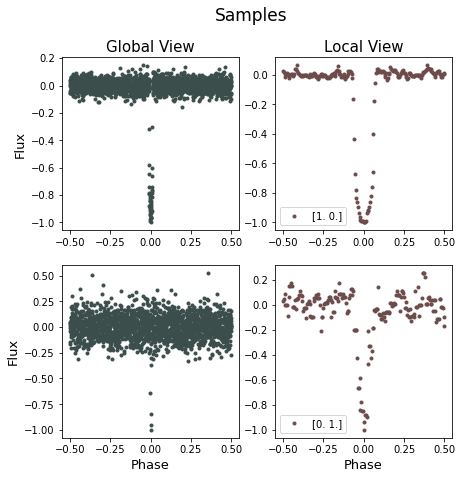

In [18]:
fig,ax=plt.subplots(2,2,figsize=(7,7))

i=0
ca=[14,15]
tab=0
xax1=np.linspace(-0.5,0.5,201)
xax2=np.linspace(-0.5,0.5,2001)
plt.suptitle('Samples', size=17)
ax[tab][0].set_title('Global View',size=15)
ax[tab][1].set_title('Local View',size=15)
ax[1][0].set_xlabel('Phase',size=13)
ax[1][1].set_xlabel('Phase',size=13)
while tab<2:
    
    #if(Ytrain[i][0]==0): continue
    ax[tab][0].set_ylabel('Flux',size=13)
    ax[tab][1].plot(xax1,Xtrainl[ca[i]],label=(Ytrain[ca[i]]),marker='.', ls='None', color="#6d4b4b")
    ax[tab][0].plot(xax2,Xtrain[ca[i]],marker='.', ls='None', color="#3c4e4b")
    ax[tab][1].legend()
    tab+=1
    i+=1

plt.savefig('fprez_pl_fps.jpg')
    

In [42]:
X_train=np.loadtxt('training_data/Xtrain_av_clean.csv',delimiter=',')
X_trainl=np.loadtxt('training_data/Xtrainloc_av_clean.csv',delimiter=',')
Y_train=np.loadtxt('training_data/Ytrain_av_clean.csv',delimiter=',')

#X_train=[el-np.median(el) for el in X_train]
#X_train=[el/np.abs(el[np.argmin(el)]) for el in X_train]
#X_train=np.array(X_train)
#X_trainl=[el-np.median(el) for el in X_trainl]
#X_trainl=[el/np.abs(el[np.argmin(el)]) for el in X_trainl]
#X_trainl=np.array(X_trainl)
#Ytrain_ref=np.loadtxt('training_data/YtrainR_big.csv',delimiter=',')
#Ytest_ref=np.loadtxt('training_data/YtestR_big.csv',delimiter=',')
Xtrain, Xtest, Xtrainl, Xtestl, Ytrain, Ytest = train_test_split(X_train, X_trainl, Y_train, test_size=0.1)
print(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape)

(3220, 2000) (3220, 2) (358, 2000) (358, 2)


In [19]:

#add hidden layers
def sandv():
     conv_ip = keras.layers.Input(shape=(2001,),name='Input')
     conv_ipl = keras.layers.Input(shape=(201,),name='LInput')
     x=keras.layers.Reshape((2001, 1), input_shape=(2001,),name='reshape_1')(conv_ip)
     x=keras.layers.BatchNormalization()(x)
     x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='conv16_5')(x) 
     x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='second_conv16_5')(x)
     x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_1')(x)
     x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5')(x)
     x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5')(x)
     x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_2')(x)
     x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv64_5')(x)
     x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv64_5')(x)
     x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_3')(x)
     x=keras.layers.Conv1D(128,kernel_size=5,strides=1,activation='relu',name='first_conv128_5')(x)
     x=keras.layers.Conv1D(128,kernel_size=5,strides=1,activation='relu',name='second_conv128_5')(x)
     x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_4')(x)
     x=keras.layers.Conv1D(256,kernel_size=5,strides=1,activation='relu',name='first_conv256_5')(x)
     x=keras.layers.Conv1D(256,kernel_size=5,strides=1,activation='relu',name='second_conv256_5')(x)
     x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_5')(x)
     x=keras.layers.Flatten(name='flat_1')(x)
     x=keras.Model(conv_ip,x,name='global')

     x2=keras.layers.Reshape((201, 1), input_shape=(201,),name='Lreshape_1')(conv_ipl)
     x2=keras.layers.BatchNormalization()(x2)
     x2=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='Lconv16_5')(x2) 
     x2=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='Lsecond_conv16_5')(x2)
     x2=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='Lmaxpool_1')(x2)
     x2=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='Lfirst_conv32_5')(x2)     
     x2=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='Lsecond_conv32_5')(x2)
     x2=keras.layers.MaxPool1D(5 ,strides=2,data_format='channels_last',name='Lmaxpool_2')(x2)
     x2=keras.layers.Flatten(name='flat_2')(x2)
     x2=keras.Model(conv_ipl,x2,name='global')

     x3=keras.layers.concatenate([x.output,x2.output],name="combine")

     x3=keras.layers.Dense(512,name='dense_layer_1',activation='relu')(x3)
     x3=keras.layers.Dense(512,name='dense_layer_2',activation='relu')(x3)
     x3=keras.layers.Dense(512,name='dense_layer_3',activation='relu')(x3)
     x3=keras.layers.Dense(512,name='dense_layer_u',activation='relu')(x3)
     #x3=keras.layers.Dense(1,name='dense_layer_4',activation='relu')(x3)
     conv_op=keras.layers.Dense(2,name='dense_layer_5',activation='softmax')(x3)


     convNN = keras.Model(inputs=[conv_ip,conv_ipl], outputs=conv_op,name='Convolutional_NN')
     convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=10**(-8)),
         loss='categorical_crossentropy',metrics=['accuracy'])
     #convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000005),loss='categorical_crossentropy',metrics=['accuracy'])
     return(convNN)


#convNN.summary()
#

In [20]:
convNN = sandv()

In [22]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
#convNN = sandv()
history=convNN.fit([np.array(Xtrain),np.array(Xtrainl)],np.array(Ytrain), batch_size=64, epochs=30, verbose=VERBOSE, 
    validation_data=([Xval,Xvall],Yval))
#history=convNN.fit([np.asarray(Xtrain),np.asarray(Xtrainl)],np.asarray(Ytrain[:,0:2]), batch_size=64, epochs=20, verbose=VERBOSE, 
#    validation_split=0.2)

Epoch 1/30
126/126 [==============================] - 55s 316ms/step - loss: 0.3830 - accuracy: 0.8123 - val_loss: 0.3837 - val_accuracy: 0.7798
Epoch 2/30
126/126 [==============================] - 36s 282ms/step - loss: 0.2442 - accuracy: 0.9005 - val_loss: 0.2653 - val_accuracy: 0.8909
Epoch 3/30
126/126 [==============================] - 36s 282ms/step - loss: 0.2287 - accuracy: 0.9107 - val_loss: 0.2404 - val_accuracy: 0.9099
Epoch 4/30
126/126 [==============================] - 36s 283ms/step - loss: 0.2186 - accuracy: 0.9128 - val_loss: 0.2366 - val_accuracy: 0.9069
Epoch 5/30
126/126 [==============================] - 36s 283ms/step - loss: 0.2091 - accuracy: 0.9181 - val_loss: 0.2200 - val_accuracy: 0.9169
Epoch 6/30
126/126 [==============================] - 36s 282ms/step - loss: 0.2018 - accuracy: 0.9216 - val_loss: 0.2319 - val_accuracy: 0.9169
Epoch 7/30
126/126 [==============================] - 36s 282ms/step - loss: 0.1927 - accuracy: 0.9243 - val_loss: 0.2267 - val_ac

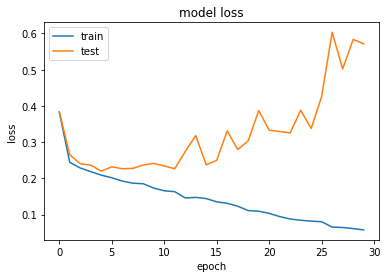

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Mloss_SandN_tot_actual_un.png')
plt.show()

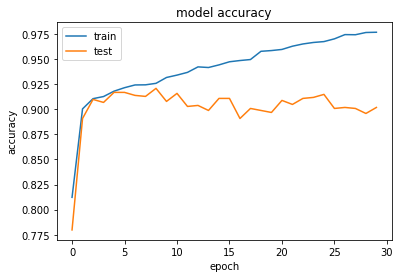

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('macc_SandN_actual_un.png')
plt.show()

In [56]:
rKFold = KFold(n_splits=5)
kfold = rKFold.split(Xtrain, Ytrain)
scores = []
#
#
es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

for k, (train, test) in enumerate(kfold):
    convNN = sandv()
    convNN.fit([Xtrain[train, :],Xtrainl[train, :]], Ytrain[train], epochs=30, verbose=1, callbacks=[es_callback])
    score = convNN.evaluate([Xtrain[test, :],Xtrainl[test, :]], Ytrain[test])
    scores.append(score)
    convNN.save_weights('CVm_snv'+str(k+1)+'.h5')
    #print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(Ytrain[train]), score))
 
#print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Epoch 1/30
81/81 [==============================] - 14s 157ms/step - loss: 0.6931 - accuracy: 0.5854
Epoch 2/30
81/81 [==============================] - 13s 156ms/step - loss: 0.6926 - accuracy: 0.6060
Epoch 3/30
81/81 [==============================] - 13s 157ms/step - loss: 0.6921 - accuracy: 0.6099
Epoch 4/30
81/81 [==============================] - 13s 156ms/step - loss: 0.6913 - accuracy: 0.6091
Epoch 5/30
81/81 [==============================] - 13s 157ms/step - loss: 0.6901 - accuracy: 0.6134
Epoch 6/30
81/81 [==============================] - 13s 157ms/step - loss: 0.6896 - accuracy: 0.6188
Epoch 7/30
81/81 [==============================] - 13s 156ms/step - loss: 0.6883 - accuracy: 0.6180
Epoch 8/30
81/81 [==============================] - 13s 157ms/step - loss: 0.6874 - accuracy: 0.6231
Epoch 9/30
81/81 [==============================] - 13s 156ms/step - loss: 0.6874 - accuracy: 0.6273
Epoch 10/30
81/81 [==============================] - 13s 157ms/step - loss: 0.6875 - accura

In [57]:
print(scores)
print(np.asarray(scores)[:,1].mean())
print(np.asarray(scores)[:,1].std())

[[0.6968616247177124, 0.5885093212127686], [0.6926734447479248, 0.5512422323226929], [0.6927766799926758, 0.5372670888900757], [0.6013959646224976, 0.6180124282836914], [0.6221875548362732, 0.5124223828315735]]
0.5614906907081604
0.037481264213185324


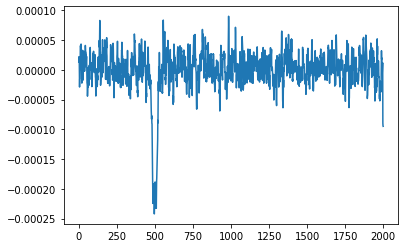

In [9]:
#testing the feature map
#Y=featuresNN.predict(np.array(Xtrain[:10]))
#sep=[[Y[i][j][1] for i in range(10)] for j in range(7)]
#plt.imshow(sep)
plt.plot(Xtrain[4])
#[plt.scatter(i,Y[0][i][2],color='green') for i in range(0,7)]
#[plt.scatter(i,Y[0][i][3],color='black') for i in range(0,7)]
plt.show()

In [26]:
#convNN.load_weights('tempforanalysis.h5')
test_loss, test_acc = convNN.evaluate([np.array(Xtest),np.array(Xtestl)], np.array(Ytest[:,0:2]))
print('Test accuracy:', test_acc)
Ypred_raw=convNN.predict([np.array(Xtest),np.array(Xtestl)])
Ytrain_raw=convNN.predict([np.array(Xtrain),np.array(Xtrainl)])
Yval_raw=convNN.predict([np.array(Xval),np.array(Xvall)])
Ypred=np.argmax(Ypred_raw, axis=1)
Ytest_new=np.argmax(Ytest,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)

32/32 [==============================] - 2s 59ms/step - loss: 0.4750 - accuracy: 0.9134
Test accuracy: 0.9134328365325928
[[309  38]
 [ 49 609]]


In [51]:
print(Ypred_raw)

[[0.18195003 0.8180499 ]
 [0.10612641 0.8938735 ]
 [0.16748644 0.8325136 ]
 ...
 [0.4605119  0.53948814]
 [0.52325886 0.47674116]
 [0.09059687 0.9094031 ]]


In [31]:
#write out the predictions of the test sample here...
net=np.asarray([[TestID2[i],Ytest[i],Ypred_raw[i]] for i in range(len(TestID2))], dtype='object')
gc.write_tfr_record('../../training_data/jointanalysis_test',net,['id','true_label','pred_label'],['b','ar','ar']
    ,['string','bool','float32'])

net=np.asarray([[TrainID2[i],Ytrain[i],Ytrain_raw[i]] for i in range(len(TrainID2))], dtype='object')
gc.write_tfr_record('../../training_data/jointanalysis_train',net,['id','true_label','pred_label'],['b','ar','ar']
    ,['string','bool','float32'])

net=np.asarray([[ValID2[i],Yval[i],Yval_raw[i]] for i in range(len(ValID2))], dtype='object')
gc.write_tfr_record('../../training_data/jointanalysis_val',net,['id','true_label','pred_label'],['b','ar','ar']
    ,['string','bool','float32'])

Wrote 1005 elements to TFRecord
Wrote 8048 elements to TFRecord
Wrote 999 elements to TFRecord


999

In [21]:
#convNN.save_weights('conv_LocalGlobal_main_un.h5')

In [38]:
#convNN.load_weights('conv_LocalGlobal_main1.h5')
#convNN.save('Model_LocalGlobal_main1.h5')

In [8]:
test_loss, test_acc = convNN.evaluate([np.array(Xtest),np.array(Xtestl)], np.array(Ytest))
print('Test accuracy:', test_acc)
Ypred_raw=convNN.predict([np.array(Xtest),np.array(Xtestl)])
Ypred=np.argmax(Ypred_raw, axis=1)
Ytest_new=np.argmax(Ytest,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)

50/50 [==============================] - 3s 56ms/step - loss: 0.4354 - accuracy: 0.9409
Test accuracy: 0.9409148693084717
[[ 302   58]
 [  35 1179]]


(1574,) (1574,)
0.9182180120812741
(91,) (91,) (91,)


Text(0, 0.5, 'True Positive Rate')

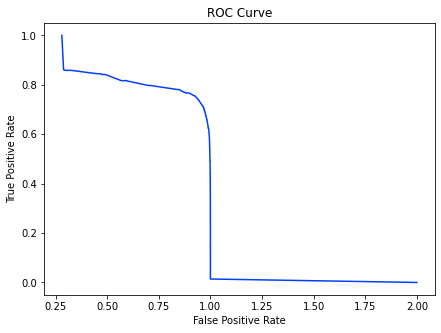

In [34]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
print(Ypred_raw[:,0].shape,Ytest[:,0].shape)
fpr , tpr, thes= roc_curve(Ytest[:,0],Ypred_raw[:,0],pos_label=1)
print(auc(fpr,tpr))
print(fpr.shape,tpr.shape,thes.shape)
plt.style.use('seaborn-bright')
plt.figure(figsize=(7,5))
plt.plot(thes,tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.savefig('sandv_ROC')


In [60]:
convNN.load_weights('conv_LocalGlobal.h5')
convNN.summary()

Model: "Convolutional_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 2000)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2000, 1)      0           Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 2000, 1)      4           reshape_1[0][0]                  
__________________________________________________________________________________________________
conv16_5 (Conv1D)               (None, 1996, 16)     96          batch_normalization_16[0][0]     
___________________________________________________________________________________

12/12 [==============================] - 1s 41ms/step - loss: 0.2797 - accuracy: 0.9246
Test accuracy: 0.924580991268158
[[146  19]
 [  8 185]]
(358,) (358,)
0.965049458313707
(43,) (43,) (43,)


Text(0, 0.5, 'True Positive Rate')

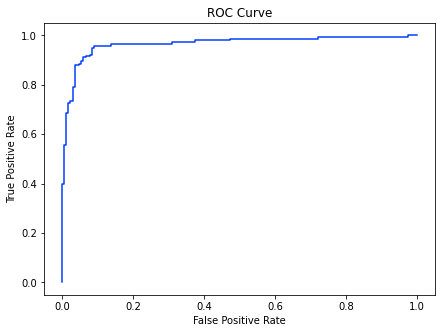

In [66]:
test_loss, test_acc = convNN.evaluate([np.asarray(Xtest),np.asarray(Xtestl)], np.asarray(Ytest))
print('Test accuracy:', test_acc)
Ypred_raw=convNN.predict([np.array(Xtest),np.array(Xtestl)])
Ypred=np.argmax(Ypred_raw, axis=1)
Ytest_new=np.argmax(Ytest,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)

print(Ypred_raw[:,1].shape,Ytest[:,1].shape)
fpr , tpr, thes= roc_curve(Ytest[:,1],Ypred_raw[:,1],pos_label=1)
print(auc(fpr,tpr))
print(fpr.shape,tpr.shape,thes.shape)
plt.style.use('seaborn-bright')
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.savefig('ROCmine')